In [2]:
from braincoder.models import GaussianPRF2DWithHRF
from braincoder.hrf import SPMHRFDerivativeModel
from braincoder.utils import logit
from braincoder.optimize import ParameterFitter
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.math import sigmoid
from braincoder.utils.data import load_szinte2024
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

data = load_szinte2024()
paradigm = data['stimulus']
grid_coordinates = data['grid_coordinates']
d = data['v1_timeseries']
d.index.name = 'frame'
tr = data['tr']

/Users/gdehol/mambaforge/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/gdehol/git/braincoder/braincoder/utils/data.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


## HRF Parameters are not fit - Results as Expected

Working with chunk size of 1879


100%|██████████| 1/1 [00:02<00:00,  2.57s/it]


*** Fitting: ***
 * x
 * y
 * sd
 * baseline
 * amplitude
Number of problematic voxels (mask): 57
Number of voxels remaining (mask): 2308


Current R2: 0.07260/Best R2: 0.07260: 100%|██████████| 1000/1000 [03:14<00:00,  5.15it/s]


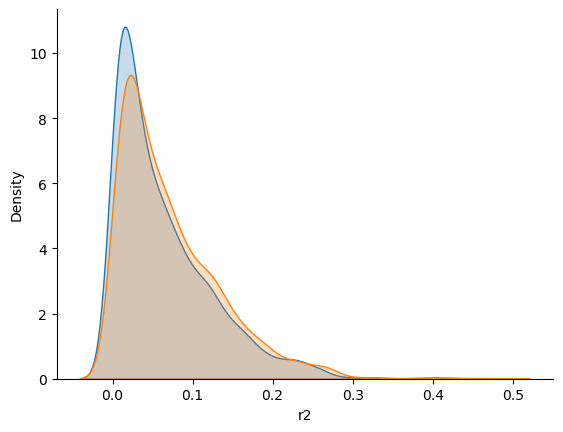

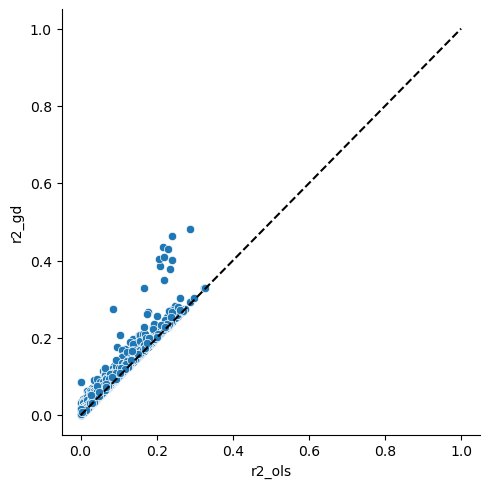

In [3]:
hrf_model = SPMHRFDerivativeModel(tr)
model_gauss = GaussianPRF2DWithHRF(data=d, paradigm=paradigm, hrf_model=hrf_model, grid_coordinates=grid_coordinates)
par_fitter = ParameterFitter(model=model_gauss, data=d, paradigm=paradigm)
x = np.linspace(-8, 8, 10)
y = np.linspace(-4, 4, 10)
sd = np.linspace(0.1, 4, 10)


baseline = [0.0]
amplitude = [1.0]

pars_gauss_grid = par_fitter.fit_grid(x, y, sd, baseline, amplitude, correlation_cost=True)
pars_gauss_ols = par_fitter.refine_baseline_and_amplitude(pars_gauss_grid)
r2_gauss_ols = par_fitter.get_rsq(pars_gauss_ols)
sns.kdeplot(r2_gauss_ols, fill=True)
sns.despine()

pars_gauss_gd = par_fitter.fit(init_pars=pars_gauss_ols, max_n_iterations=1000)
r2_gauss_gd = par_fitter.get_rsq(pars_gauss_gd)
sns.kdeplot(r2_gauss_gd, fill=True)

r2 = pd.concat((r2_gauss_ols, r2_gauss_gd), keys=['r2_ols', 'r2_gd'], axis=1)
sns.relplot(x='r2_ols', y='r2_gd', data=r2.reset_index(), kind='scatter')
plt.plot([0, 1], [0, 1], 'k--')

*** Fitting: ***
 * x
 * y
 * sd
 * baseline
 * amplitude
 * delay_weight
 * dispersion_weight
Number of problematic voxels (mask): 57
Number of voxels remaining (mask): 2308


  0%|          | 0/1000 [00:00<?, ?it/s]

(1, 150, 2365) (24, 2365)


Current R2: 0.10075/Best R2: 0.10076: 100%|██████████| 1000/1000 [03:08<00:00,  5.31it/s]


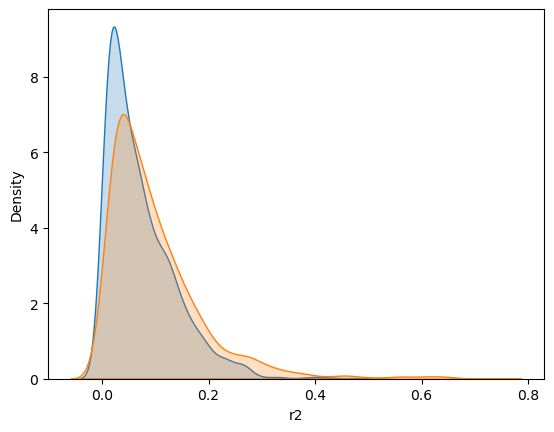

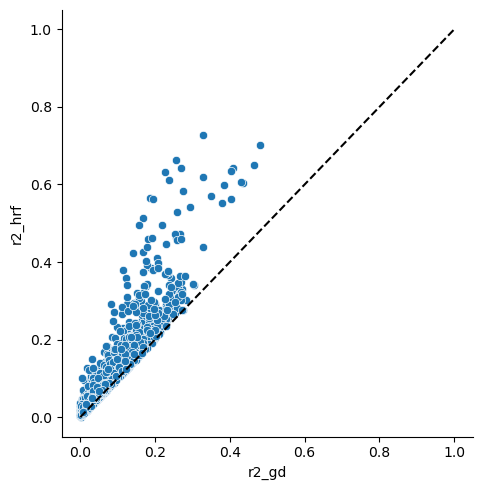

In [5]:

model_hrf = GaussianPRF2DWithHRF(data=d, paradigm=paradigm, hrf_model=hrf_model,
                             grid_coordinates=grid_coordinates, flexible_hrf_parameters=True)

par_fitter_hrf = ParameterFitter(model=model_hrf, data=d, paradigm=paradigm)

pars_gauss_gd['delay_weight'] = 0.
pars_gauss_gd['dispersion_weight'] = 0.

pars_gauss_hrf = par_fitter_hrf.fit(init_pars=pars_gauss_gd, max_n_iterations=1000, store_intermediate_parameters=True, learning_rate=0.01)
r2_gauss_hrf = par_fitter_hrf.get_rsq(pars_gauss_hrf)

sns.kdeplot(r2_gauss_gd, fill=True)
sns.kdeplot(r2_gauss_hrf, fill=True)

r2 = pd.concat((r2_gauss_gd, r2_gauss_hrf), keys=['r2_gd', 'r2_hrf'], axis=1)
sns.relplot(x='r2_gd', y='r2_hrf', data=r2.reset_index(), kind='scatter')
plt.plot([0, 1], [0, 1], 'k--')

/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_18714/1381862822.py:8: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  tmp = pred.stack(['model', 'source']).to_frame('value')


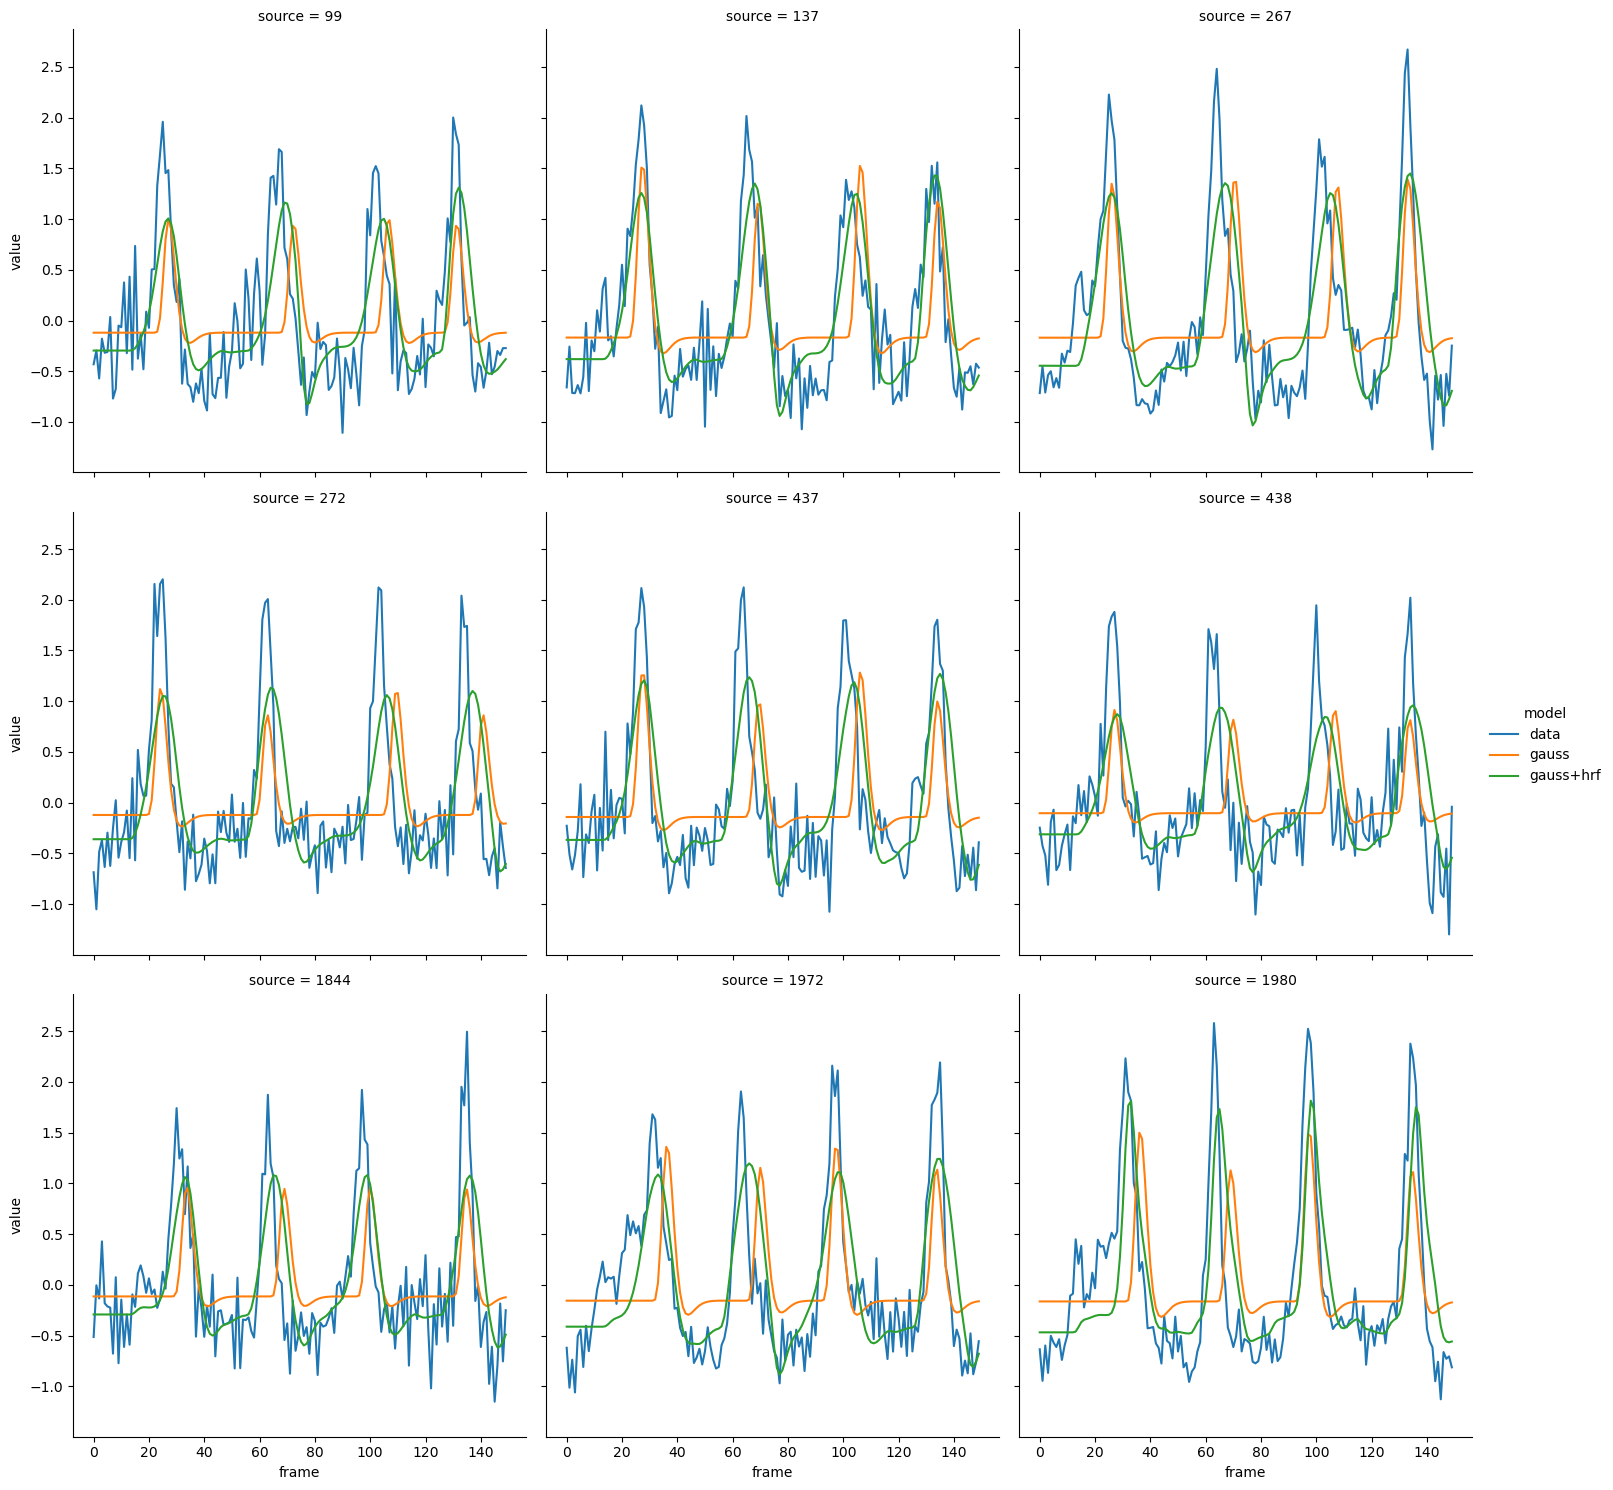

In [6]:
improvement = r2_gauss_hrf - r2_gauss_gd
largest_improvements = improvement.sort_values(ascending=False).index[:9]
pred_gauss_gd = model_gauss.predict(parameters=pars_gauss_gd)
pred_gauss_hrf = model_hrf.predict(parameters=pars_gauss_hrf)
pred = pd.concat((d.loc[:, largest_improvements], pred_gauss_gd.loc[:, largest_improvements], pred_gauss_hrf.loc[:, largest_improvements]), axis=1, keys=['data', 'gauss', 'gauss+hrf'], names=['model'])

#
tmp = pred.stack(['model', 'source']).to_frame('value')
sns.relplot(x='frame', y='value', hue='model', col='source', data=tmp.reset_index(), kind='line', col_wrap=3)

<Axes: xlabel='delay_weight', ylabel='Count'>

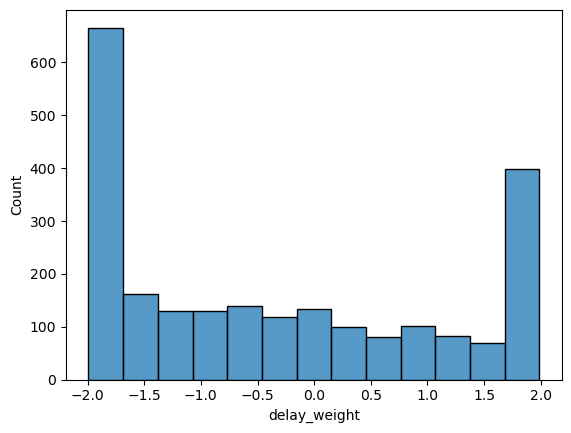

In [8]:
mask = pars_gauss_hrf['x'] != 0.0
sns.histplot(pars_gauss_hrf[mask]['delay_weight'])

<Axes: xlabel='dispersion_weight', ylabel='Count'>

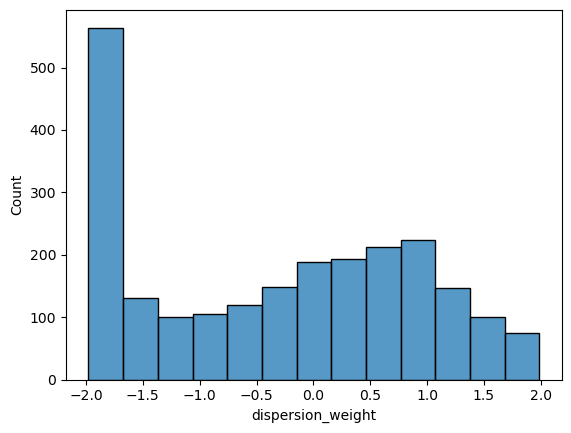

In [11]:
sns.histplot(pars_gauss_hrf[mask]['dispersion_weight'])